#Generative Adversarial Networks (GANs)

In this notebook, you will train a simple GAN on a subset of the CelebA dataset.

This notebook is based upon PyTorch's DCGAN Tutorial, that can be found [here](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

## Data Preparation

In [2]:
# Load the zip file available in Moodle and unzip it
!unzip "/content/drive/MyDrive/subset_celeba.zip"

Streaming output truncated to the last 5000 lines.
  inflating: subset_celeba/149086.jpg  
  inflating: subset_celeba/119869.jpg  
  inflating: subset_celeba/192669.jpg  
  inflating: subset_celeba/170834.jpg  
  inflating: subset_celeba/194218.jpg  
  inflating: subset_celeba/183764.jpg  
  inflating: subset_celeba/015712.jpg  
  inflating: subset_celeba/105273.jpg  
  inflating: subset_celeba/017105.jpg  
  inflating: subset_celeba/142138.jpg  
  inflating: subset_celeba/049079.jpg  
  inflating: subset_celeba/057247.jpg  
  inflating: subset_celeba/002508.jpg  
  inflating: subset_celeba/004179.jpg  
  inflating: subset_celeba/146438.jpg  
  inflating: subset_celeba/054982.jpg  
  inflating: subset_celeba/185467.jpg  
  inflating: subset_celeba/070834.jpg  
  inflating: subset_celeba/009449.jpg  
  inflating: subset_celeba/059518.jpg  
  inflating: subset_celeba/089249.jpg  
  inflating: subset_celeba/042886.jpg  
  inflating: subset_celeba/072945.jpg  
  inflating: subset_celeba/19

In [3]:
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = os.listdir(self.root_dir)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    img = Image.open(img_path).convert('RGB')
    if self.transform:
      img = self.transform(img)

    return img

Total number of images: 9782


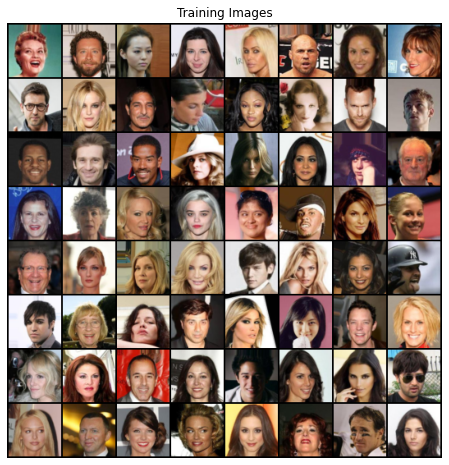

In [6]:
workers = 2
batch_size = 128
image_size = 64

transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
dataset = CelebADataset('/content/subset_celeba', transform=transform)
print("Total number of images:", len(dataset))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Model Definition

In [7]:
# Custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ndf=64, nc=3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [11]:
# Create the discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Model Training

The first step is to train the discriminator. Remember that, for each training epoch, half of a batch should contain real images and the other half synthetic images. The synthetic images are created by the generator. Then, train the generator.


In [16]:
lr = 0.0002
num_epochs = 50

criterion = nn.BCELoss()

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lr)
optimizerG = optim.Adam(netG.parameters(), lr=lr)

In [17]:
# Training Loop

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()

        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats at every 50 iterations
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/77]	Loss_D: 0.0478	Loss_G: 0.0572	D(x): 0.9620	D(G(z)): 0.0016 / 0.9539
[0/50][50/77]	Loss_D: 0.0933	Loss_G: 7.3799	D(x): 0.9554	D(G(z)): 0.0287 / 0.0030
[1/50][0/77]	Loss_D: 0.1640	Loss_G: 7.8616	D(x): 0.9473	D(G(z)): 0.0524 / 0.0049
[1/50][50/77]	Loss_D: 0.4969	Loss_G: 6.0464	D(x): 0.9096	D(G(z)): 0.2238 / 0.0074
[2/50][0/77]	Loss_D: 0.0964	Loss_G: 5.9545	D(x): 0.9548	D(G(z)): 0.0231 / 0.0076
[2/50][50/77]	Loss_D: 0.1198	Loss_G: 7.7214	D(x): 0.9696	D(G(z)): 0.0558 / 0.0023
[3/50][0/77]	Loss_D: 0.0837	Loss_G: 8.4906	D(x): 0.9540	D(G(z)): 0.0119 / 0.0017
[3/50][50/77]	Loss_D: 0.0390	Loss_G: 7.6635	D(x): 0.9832	D(G(z)): 0.0189 / 0.0027
[4/50][0/77]	Loss_D: 0.1877	Loss_G: 5.6457	D(x): 0.9543	D(G(z)): 0.0959 / 0.0148
[4/50][50/77]	Loss_D: 0.0517	Loss_G: 7.8606	D(x): 0.9710	D(G(z)): 0.0161 / 0.0011
[5/50][0/77]	Loss_D: 0.1382	Loss_G: 8.4987	D(x): 0.9021	D(G(z)): 0.0027 / 0.0010
[5/50][50/77]	Loss_D: 0.0555	Loss_G: 7.0604	D(x): 0.9895	D(G(z)): 0.0351 / 0.0

## Training Evolution

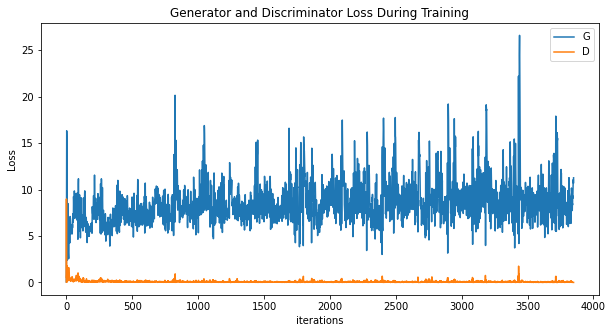

In [18]:
# Plot the evolution of the generator and discriminator losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

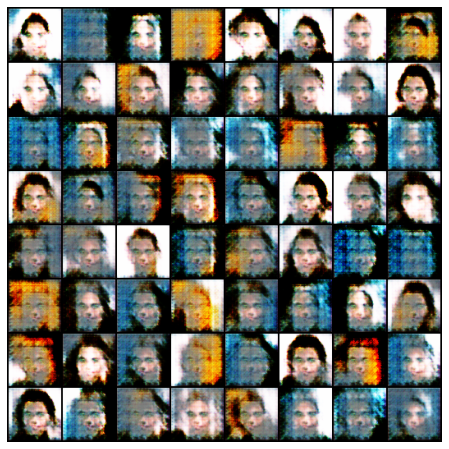

In [19]:
# Plot the evolution of the generated images on fixed noise for fair comparison
#%%capture
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Challenge

Train the GAN on the entire CelebA dataset.